## Using Isolation Forest to Detect Criminally-Linked Properties

The goal of this notebook is to apply the Isolation Forest anomaly detection algorithm to the property data. The algorithm is particularly good at detecting anomalous data points in cases of extreme class imbalance. After normalizing the data and splitting into a training set and testing set, I trained the first model. 

Because the rate of criminally-linked properties in the data is only 0.00885%, I chose to start with a very low contamination parameter (the proportion of outliers in the data). After visualizing this first model's poor performance, I was hopeful that gridsearching would provide a model with better performance.

Lastly, I manually selected a few features that, based on my experience investigating money-laundering and asset tracing, I thought would be most important and trained a model on just those.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, precision_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('dark')

#### Load Data and Remove Columns

In [2]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_processed.h5')

# Fill na values where crim_prop==1 with 0
df.loc[df.crim_prop==1,'price_psf'] = df.loc[df.crim_prop==1,'price_psf'].fillna(0)
# Filter out wonky situations (erroneous property encoding, sq footage of 1, etc.)
trim_prop_df = df[(df.price_psf<df.price_psf.quantile(.999)) | (df.price_psf.isna())]

In [3]:
# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = trim_prop_df[variables_list]
df_if = sub_df.dropna()
print("Number of properties after trimming:", len(df_if))

Number of properties after trimming: 530923


In [4]:
# Get criminal property rate
crim_prop_rate = 1 - (len(df_if[df_if['crim_prop']==0]) / len(df_if))
print("Rate is: {:.5%}".format(crim_prop_rate))

Rate is: 0.00885%


In [5]:
# Re-label the normal properties with 1 and the criminal ones with -1
df_if['binary_y'] = [1 if x==0 else -1 for x in df_if.crim_prop]
print(df_if.binary_y.value_counts())

 1    530876
-1        47
Name: binary_y, dtype: int64


/Users/matthewpokorny/anaconda3/envs/property_project_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
# Normalize the data
X = df_if.iloc[:,:-2]
X_norm = preprocessing.normalize(X)

y = df_if.binary_y

# Split the data into train and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y, test_size=0.33, random_state=42
)

#### First Model - All Features Included

For the first model, I included all the features and set the contamination to 0.01, because the class imbalance is so high.

In [7]:
# Set parameters
clf = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

# Fit the model
clf.fit(X_train_norm,y_train_norm)
# Predict
y_pred_train = clf.predict(X_train_norm)

In [21]:
# Define function to plot resulting confusion matrix
def plot_confusion_matrix(conf_matrix, title, classes=['criminally-linked', 'normal'],
                          cmap=plt.cm.Oranges):

    # Plot confusion matrix with heatmap and classification statistics
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar(pad=.12)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=11)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=11)

    fmt = '.4%'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 fontsize=16,
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label',fontsize=14, rotation=0)
    plt.xlabel('Predicted label',fontsize=14)

#### Model Performance on Training Data

In [35]:
# Function for returning the model metrics
def metrics_iforest(y_true,y_pred):
    
    print('Model recall is',recall_score(
        y_true,
        y_pred,
        zero_division=0,
        pos_label=-1
    ))
    print('Model precision is',precision_score(
        y_true,
        y_pred,
        zero_division=0,
        pos_label=-1
    ))

    print("Model AUC is", roc_auc_score(y_true, y_pred))

In [36]:
metrics_iforest(y_train_norm,y_pred_train)

Model recall is 0.2
Model precision is 0.0016863406408094434
Model AUC is 0.5950068599446705


[[     6     24]
 [  3552 352136]]


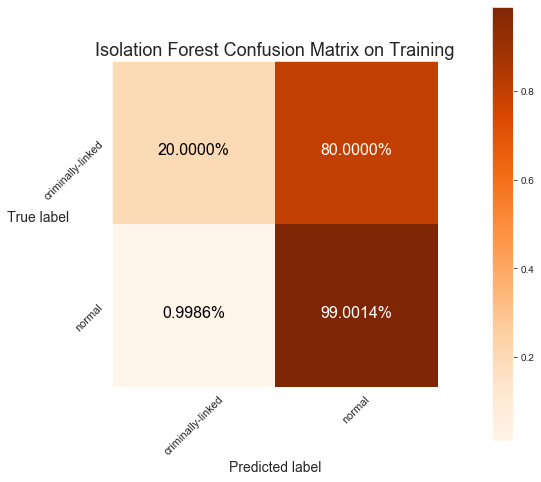

In [23]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training')

The model performs quite poorly at two important metrics in a classification problem such as this, recall and precision. Missing 80% of all criminally-linked properties makes for a bad anomaly detector.

#### Gridsearch

Isolation Forest is fairly robust to parameter changes, but changing the contamination can improve performance. I will gridsearch based on a range of contamination from 0.01 to 0.25 in leaps of 0.05. 

In [25]:
%%time
skip = 1
if skip == 0:
    # Set what metrics to evaluate predictions
    scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

    gs = GridSearchCV(
        IsolationForest(max_samples=0.25, random_state=42,n_estimators=100),
        param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
        scoring=scoring, 
        refit='Recall',
        verbose=0,
        cv=3
    )
    
    # Fit to training data
    gs.fit(X_train_norm,y_train_norm)

CPU times: user 6min 15s, sys: 56.2 s, total: 7min 12s
Wall time: 7min 40s


In [26]:
print(gs.best_params_)

{'contamination': 0.11}


#### Gridsearch Model Performance on Training

In [38]:
y_pred_train_gs = gs.predict(X_train_norm)
metrics_iforest(y_train_norm,y_pred_train_gs)

Model recall is 0.9333333333333333
Model precision is 0.0007155817935546525
Model AUC is 0.9117013599934024


[[    28      2]
 [ 39101 316587]]


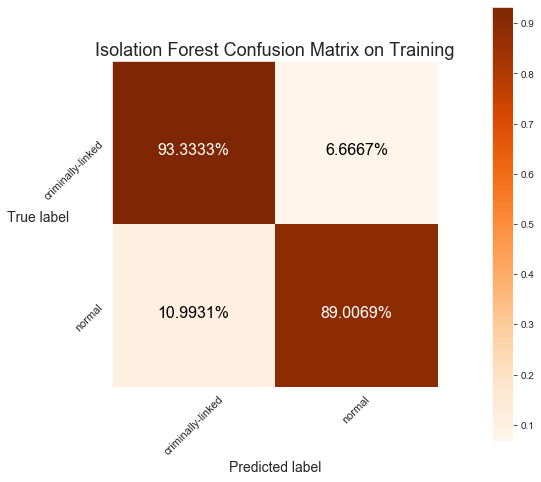

In [32]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training')

Increasing the contamination parameter drastically improved the model's recall and AUC. Precision is still poor, as there are now 39,101 false positives. Let's see if it holds up on testing data.

#### Gridsearch Model Performance on Testing

In [39]:
y_pred_test_gs = gs.predict(X_test_norm)
metrics_iforest(y_test_norm,y_pred_test_gs)

Model recall is 0.8235294117647058
Model precision is 0.0007285216214809804
Model AUC is 0.8569578697976895


[[    14      3]
 [ 19203 155985]]


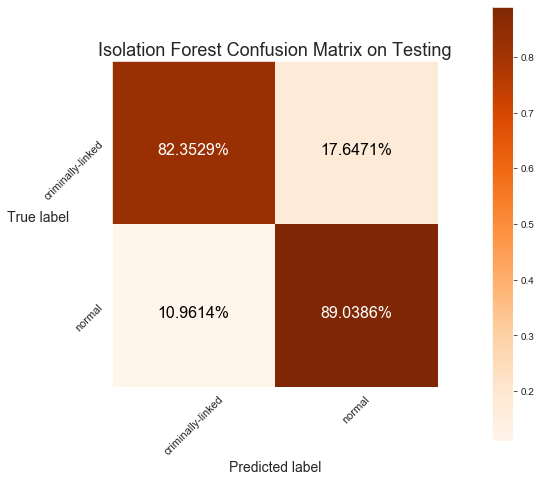

In [40]:
conf_matrix = confusion_matrix(y_test_norm, y_pred_test_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Testing')

The model does a bit worse on testing but still far better than the first attempt's performance. While the model now detects 28 out of 30 criminally-linked properties correctly on the training data, it has done so at the expense of increasing false positives from 3,552 for the first model to 39,101 for the gridsearched model. Similarly, the model has falsely labeled 19,203 properties as criminally-linked in the testing data. Because in this context I much prefer to not miss any cases of potential criminal investment or money laundering, more false positives are acceptable to reduce false negatives.

#### Visualize Distribution of Anomaly Scores

Sklearn's Isolation Forest provides anomaly scores for each property where the lower the score, the more anomalous the datapoint is.

In [43]:
# Define function for histograms of anomaly scores
def anomaly_plot(anomaly_scores,anomaly_scores_list,title):
    plt.figure(figsize=[15,9])
    plt.subplot(211)
    plt.hist(anomaly_scores,bins=100,log=False,color='royalblue')
    for xc in anomaly_scores_list:
        plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
    plt.title(title,fontsize=16)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=14)
    plt.ylabel('Number of properties',fontsize=13)

    plt.subplot(212)
    plt.hist(anomaly_scores,bins=100,log=True,color='royalblue')
    for xc in anomaly_scores_list:
        plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
    plt.xlabel('Anomaly score',fontsize=13)
    plt.ylabel('Number of properties',fontsize=13)
    plt.title('{} (Log Scale)'.format(title),fontsize=16)

    plt.show()

##### Training Data

In [48]:
# Grab anomaly scores for criminally-linked properties
train_df = pd.DataFrame(X_train_norm)
y_train_series = y_train_norm.reset_index()
train_df['y_value'] = y_train_series.binary_y
train_df['anomaly_scores'] = gs.decision_function(X_train_norm)
anomaly_scores_list = train_df[train_df.y_value==-1]['anomaly_scores']

In [53]:
print("Mean score for outlier properties:",np.mean(anomaly_scores_list))
print("Mean score for normal properties:",np.mean(train_df[train_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.041011617287932074
Mean score for normal properties: 0.008663313563756062


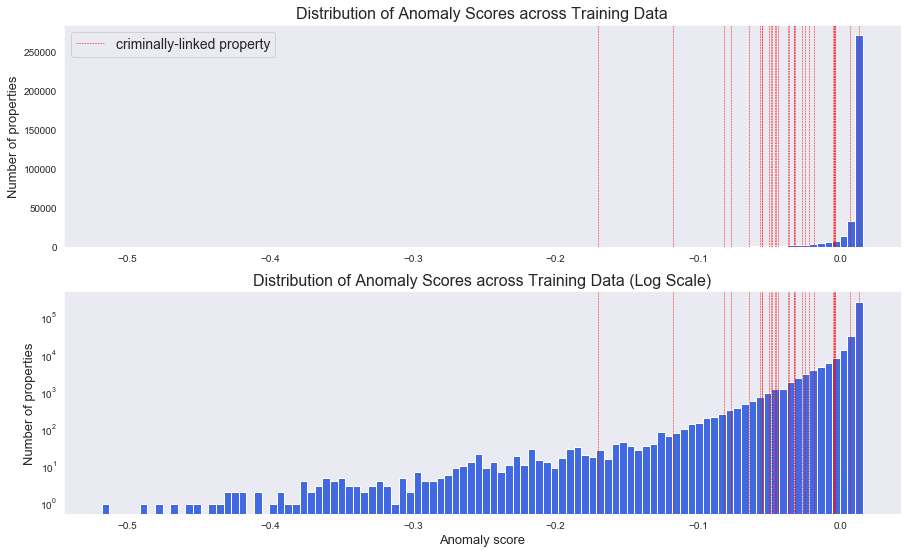

In [49]:
anomaly_plot(train_df['anomaly_scores'],
             anomaly_scores_list,
             title='Distribution of Anomaly Scores across Training Data')

##### Testing Data

In [55]:
test_df = pd.DataFrame(X_test_norm)
y_test_series = y_test_norm.reset_index()
test_df['y_value'] = y_test_series.binary_y
test_df['anomaly_scores'] = gs.decision_function(X_test_norm)
anomaly_scores_list_test = test_df[test_df.y_value==-1]['anomaly_scores']

In [56]:
print("Mean score for outlier properties:",np.mean(anomaly_scores_list_test))
print("Mean score for normal properties:",np.mean(test_df[test_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.03536345623915164
Mean score for normal properties: 0.008599072088714093


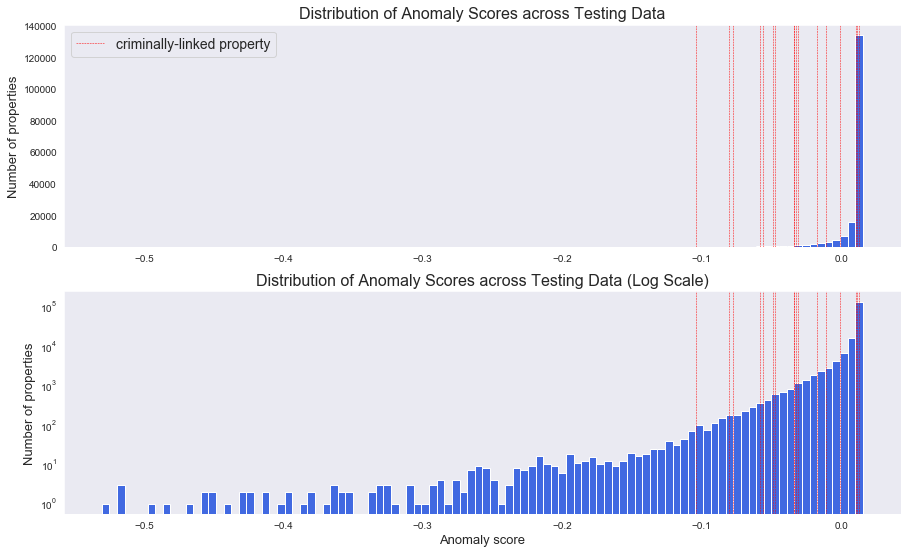

In [57]:
anomaly_plot(test_df['anomaly_scores'], anomaly_scores_list_test, title='Distribution of Anomaly Scores across Testing Data')

The top graph in each plot gives a sense of how skewed the distribution is and how relatively lower the anomaly scores for the criminally-linked properties are when compared to the greater population. The log scale histogram highlights just how many properties do have quite low anomaly scores, which the model is falsely labeling as outliers.

#### Fewer Features

With `feature_importances_` not existing for Isolation Forest, I wanted to see if I could use my background in investigating money laundering to select a few features that would be the best indicators of "abnormal" properties.

In [58]:
# Grab specific columns
X_trim = X[['partial_owner','just_established_owner',
            'foreign_based_owner','out_of_state_owner',
            'owner_legal_person','owner_likely_company',
            'owner_owns_multiple','two_gto_reqs']]

# Normalize
X_trim_norm = preprocessing.normalize(X_trim)

# Split the data into train and test
X_train_trim, X_test_trim, y_train_trim, y_test_trim = train_test_split(
    X_trim_norm, y, test_size=0.33, random_state=42
)

In [59]:
clf_trim = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.11,
    random_state=42
)

clf_trim.fit(X_train_trim,y_train_trim)
y_pred_train_trim = clf_trim.predict(X_train_trim)

##### Training Data

In [60]:
metrics_iforest(y_train_trim,y_pred_train_trim)

Model recall is 0.9
Model precision is 0.0006952491309385864
Model AUC is 0.8954465711522458


[[    27      3]
 [ 38808 316880]]


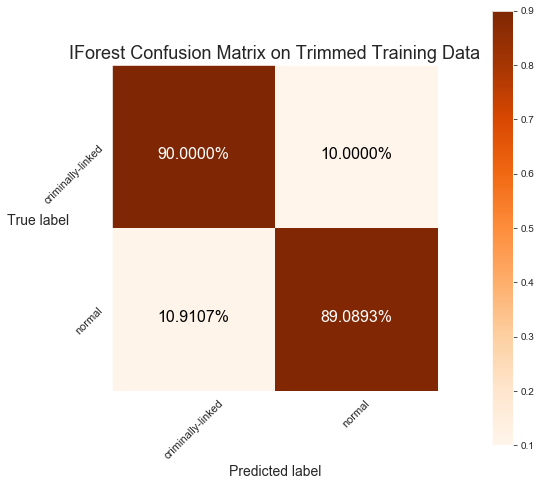

In [65]:
conf_matrix = confusion_matrix(y_train_trim, y_pred_train_trim)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='IForest Confusion Matrix on Trimmed Training Data')

Reducing the features worsens the model by one true positive and only reduces the number of false positives by 0.75% on testing data.

##### Testing Data

In [62]:
y_pred_test_trim = clf_trim.predict(X_test_trim)
metrics_iforest(y_test_trim,y_pred_test_trim)

Model recall is 0.8235294117647058
Model precision is 0.0007290907197166961
Model AUC is 0.8570006809491383


[[    14      3]
 [ 19188 156000]]


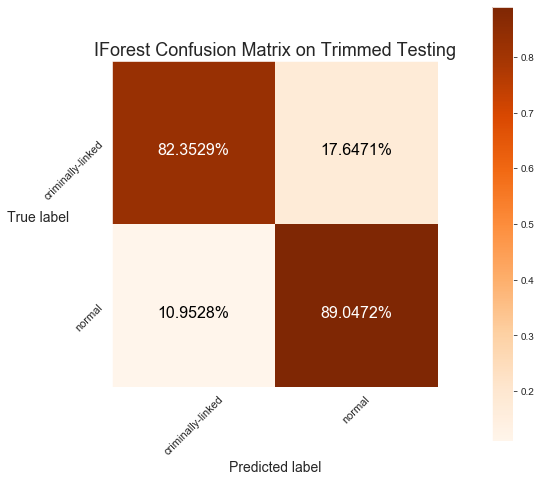

In [63]:
conf_matrix = confusion_matrix(y_test_trim, y_pred_test_trim)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='IForest Confusion Matrix on Trimmed Testing')

The model trained on the trimmed featureset predicts one more property correctly in the testing data than did the model trained on all the features. Its AUC is higher than the gridsearched, full-feature model.

#### Final Notes

- Gridsearching for the contamination parameter drastically affects the model's performance.
- The improved recall scores in the latter two models came at the expense of many more false positives. However, this is an acceptable trade-off given the context.
- It does not appear my expertise in selecting features improves performance.
- There are many properties that the models find more "anomalous" than the true positives. This could indicate the criminals have done a good job of making their properties appear relatively "normal" in the broad spectrum of residential property ownership in Bexar County. While likely not enough to make a large difference, it is quite likely there are more criminally-affiliated properties in the broader population that I have not labeled as such.